# Purity correction of LUAD

In [68]:
source("func.R")
library(ggbeeswarm)
library(ggpubr)
library(rstatix)
library(wesanderson)

In [69]:
# renaming sample names with their organ of origin
sample_names <- read_tsv("../data/purity_data/C_case_samplemap.txt")

Rows: 56 Columns: 3
-- Column specification --------------------------------------------------------
Delimiter: "\t"
chr (3): Patient_ID, Sample_ID, Real_Sample_ID

i Use `spec()` to retrieve the full column specification for this data.
i Specify the column types or set `show_col_types = FALSE` to quiet this message.


### Extracting marker lengths
Getting the minimum number of marker all samples agree on, as long as that's more than 70% of the maximum possible markers 

In [70]:
# function to get markers that are present in all samples
get_sampler_marker  <- function(sample_i, marker_tbl) {
    
    marker_tbl  %>% 
    filter(sample==sample_i)  %>% 
    pull(marker)  %>% 
    unique()
}

get_minimum_marker_table  <- function(subject_i, markerlengths){

marker_tbl <-  markerlengths  %>% 
    filter(subject==subject_i)  %>% 
    group_by(sample)  %>% 
    add_count(sample)  %>% 
    ungroup()  %>% 
    mutate(minimum_markers = max(n)*0.7) %>% 
    filter(n>minimum_markers) 
    
samples  <- unique(marker_tbl$sample)
marker_list  <- lapply(samples, get_sampler_marker, marker_tbl)
common_markers  <- Reduce(intersect, marker_list)

n_common_markers  <- length(common_markers)

markerlengths  %>% 
    filter(subject==subject_i, marker %in% common_markers)   %>% 
    group_by(sample)  %>% 
    add_count(sample)  %>% 
    filter(n==n_common_markers)  %>% 
    select(-n)
    
    }

In [71]:
# directroy of the results from polyG data with matching purity data
dir_list <- list.files("../data/purity_data/",
    pattern = "_R$", full.names = TRUE
) 
l <- purrr::map(dir_list, get_markerlengths_unsubtracted)
markerlengths_crc <- bind_rows(l) 


C146

C154

C157



In [72]:
markerlengths_crc <- markerlengths_crc %>%
    left_join(sample_names, by = c("sample" = "Sample_ID")) %>%
    mutate(sample = Real_Sample_ID, sample=paste0(subject, "_", sample)) %>%
    select(1:4)

In [73]:
# processing data 
subjects  <- unique(markerlengths_crc$subject)
minimum_marker_tbls  <- lapply(subjects, get_minimum_marker_table, markerlengths_crc)
minimum_markerlengths_crc <- bind_rows(minimum_marker_tbls) 

In [74]:
minimum_markerlengths_crc <- minimum_markerlengths_crc %>%
    mutate(normal = ifelse(str_detect(sample, "Normal"), TRUE, FALSE)) 

In [75]:
# reading in ACE-derived purities
purities <- read_tsv("../data/purity_data/C_case_pseudofits.txt") %>%
    mutate(
        sample = paste0(Patient_ID, "_", Real_Sample_ID), purity=Purity
    ) %>%
    select(sample, purity)

Rows: 45 Columns: 4
-- Column specification --------------------------------------------------------
Delimiter: "\t"
chr (2): Patient_ID, Real_Sample_ID
dbl (2): Purity, Ploidy

i Use `spec()` to retrieve the full column specification for this data.
i Specify the column types or set `show_col_types = FALSE` to quiet this message.


Adding data from E4

In [76]:
marker_dir <- list.files("../data/e4", pattern = "repre_repli", full.names = TRUE)
marker_files <- list.files(marker_dir, full.names = TRUE)

In [77]:
  ## path to poly-G raw data directory (marker length files)

  ## load marker lengths and get the average length of each marker in each sample
  get_markers <- function(marker_dir) {

  marker <- suppressMessages(read_tsv(marker_dir))
  
  # getting the marker name
  int_file <- tail(str_split(marker_dir, "/")[[1]], 1) 
  marker_name <- head(str_split(int_file, "_")[[1]], 1)

  cols <- NCOL(marker) +1 

  marker  %>% 
    rowid_to_column("length")  %>% 
    pivot_longer(cols=c(2:cols), names_to="sample", values_to="Frequency")  %>% 
    group_by(sample)  %>% 
    mutate(Frequency=Frequency/sum(Frequency),
            sample=str_remove(sample, "_[1-3]$")) %>%
    mutate(polyG=marker_name) 
    
  }
  

In [78]:
e4_markers <- lapply(marker_files, get_markers) %>%
  list_rbind()

In [79]:
purities_e4 <- read_tsv("../data/e4/E4_fits.tsv") %>%
    select(sample, pu) 

Rows: 35 Columns: 8
-- Column specification --------------------------------------------------------
Delimiter: "\t"
chr (1): sample
dbl (7): pu, pl, dipLogR, neg_mb, homdel_mb, na_mb, loglik

i Use `spec()` to retrieve the full column specification for this data.
i Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [80]:
final_samples <- purities_e4 %>%
    filter(pu > 0.3, str_detect(sample, "Liv|PT|TD|Normal")) %>% 
    pull(sample) %>% 
    c("Normal2")

Renaming old sample names

In [81]:
renamed_markers <- read_tsv("../data/e4/E4_annotationFile.txt") %>%
    right_join(e4_markers, by = c("Sample_ID" = "sample")) %>%
    dplyr::rename(sample = Real_Sample_ID) %>%
    select(-Sample_ID) %>%
    filter(sample %in% final_samples) %>%
    left_join(purities_e4)%>% 
    dplyr::rename(purity = pu) %>%
    mutate(sample = paste0("E4_", sample))

e4_meanlengths <- renamed_markers %>%
    group_by(sample, polyG, purity) %>%
    mutate(Frequency = Frequency / sum(Frequency)) %>%
    summarize(length = sum(length * Frequency)) %>%
    dplyr::rename(marker = polyG) %>%
    mutate(normal = ifelse(str_detect(sample, "Normal"), TRUE, FALSE), subject="E4") %>% 
    ungroup() %>% 
    add_count(marker) %>% 
    filter(n==max(n)) %>% 
    select(-n)
    

Rows: 47 Columns: 2
-- Column specification --------------------------------------------------------
Delimiter: "\t"
chr (2): Sample_ID, Real_Sample_ID

i Use `spec()` to retrieve the full column specification for this data.
i Specify the column types or set `show_col_types = FALSE` to quiet this message.
Joining with `by = join_by(sample)`
`summarise()` has grouped output by 'sample', 'polyG'. You can override using
the `.groups` argument.


Joining E4 to other samples

In [82]:
uncorrected_meanlengths <- minimum_markerlengths_crc %>%
    left_join(purities) %>%
    bind_rows(e4_meanlengths) %>% 
    group_by(subject, marker) %>%
    mutate(length = length - length[normal]) %>% 
    drop_na()

Joining with `by = join_by(sample)`


Checking if any of the new patients had a MMRd tumor

In [83]:
msi_samples <- uncorrected_meanlengths %>%
    group_by(subject) %>%
    mutate(large_del = (length < (-1))) %>%
    count(large_del) %>%
    mutate(del_frac = n / sum(n)) %>%
    filter(large_del, del_frac > 0.1)

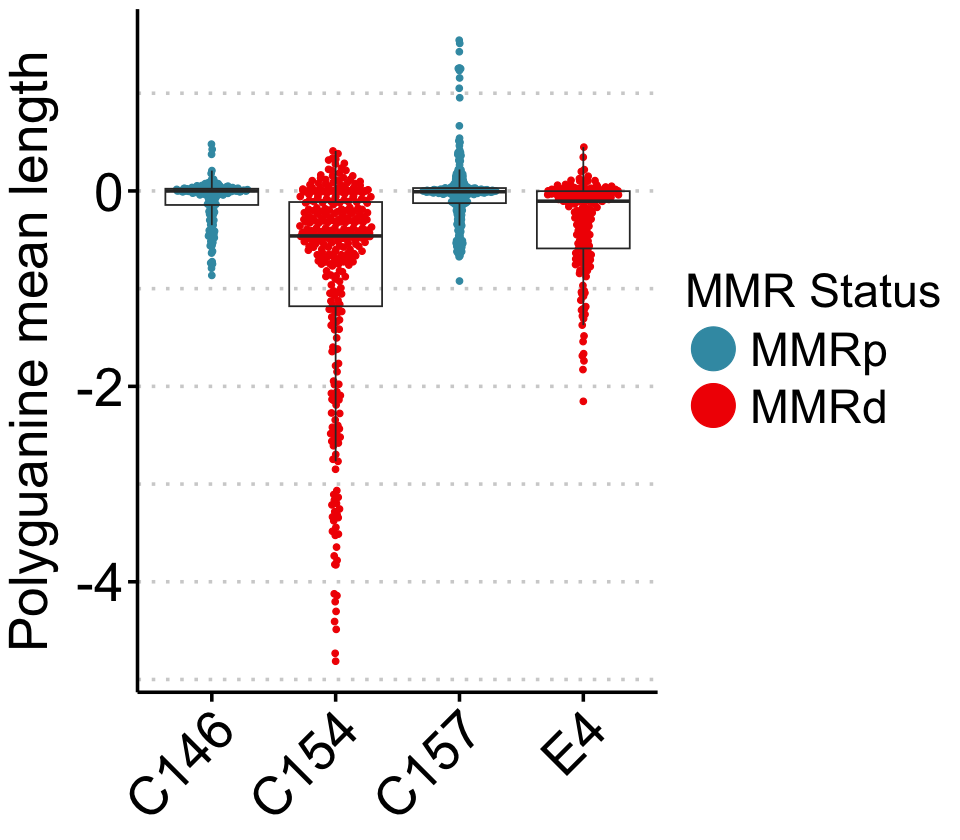

In [84]:
msi_tumors <- msi_samples$subject

# ordering subjects from lowest to highest number
subjects <- as.list((uncorrected_meanlengths) %>%
    pull(subject) %>%
    unique()) %>%
    str_sort(numeric = TRUE)
    
uncorrected_meanlengths %>%
    ungroup() %>%
    mutate(
        MSI = ifelse(subject %in% msi_samples$subject, TRUE, FALSE),
        subject = fct_relevel(subject, subjects)
    ) %>% 
    ggplot(aes(subject, length)) +
    geom_quasirandom(aes(color = MSI), width=0.3) +
    geom_boxplot(alpha = 0) +
    scale_y_continuous(breaks = seq(-10, 10, 2)) +
    scale_color_manual(
        values = c(wes_palette("Zissou1")[1], wes_palette("Zissou1")[5]),
        name = "MMR Status",
        labels = c("MMRp", "MMRd")
    ) +
    labs(y = "Polyguanine mean length") +
    theme_martin() +
    theme(
            axis.title.x = element_blank(), axis.text.x = element_text(angle = 45, hjust = 1),
            panel.grid.major.y = element_line(linewidth = 1, color = "grey82", linetype = 3),
            panel.grid.minor.y = element_line(linewidth = 1, color = "grey82", linetype = 3),
            legend.key.height = unit(20, "pt"), legend.key.width = unit(20, "pt"), 
            legend.text = element_text(size = 28), legend.title = element_text(size=28)
      ) +
    guides(colour = guide_legend(override.aes = list(size=12)))

Purity correction of markerlengths

In [85]:
corrected_meanlengths <- uncorrected_meanlengths %>%
    left_join(purities) %>%
    filter(purity>0.3)%>% 
    group_by(subject, marker) %>%
    mutate(length = (length - (1 - purity) * length[normal]) / purity) %>%
    mutate(length = length - length[normal]) %>% 
    drop_na()

Joining with `by = join_by(sample, purity)`


In [86]:
samples %>%
    str_subset("Normal", negate = T) %>%
    length()

[1] 45

In [87]:
# find samples
samples <- corrected_meanlengths$sample %>% unique

combos_wide <- combn(samples, m= 2) %>% as.data.frame()

## make combo table longer
combos_long <- data.frame(a=as.character(combos_wide[1,]), b=as.character(combos_wide[2,]))

## only use combintions from the same subject
combos <- combos_long %>% 
    mutate(sample_a = str_remove(a, "_.*"),
        sample_b = str_remove(b, "_.*")) %>% 
    filter(sample_a==sample_b) %>% 
    dplyr::select(a, b)  


In [88]:
# create a table for the L1 of non-bootstrapped marker lengths 
l1 <- lapply(1:nrow(combos), get_l1_r_for_combination, combos, corrected_meanlengths)
l1_corrected <- rbindlist(l1)

In [89]:
dist_from_normal_corrected <- l1_corrected %>%
    filter((str_detect(a, "Normal1")) | str_detect(b, "Normal1")) %>%
    mutate(sample = ifelse(str_detect(a, "Normal1"), b, a), divs = ifelse(str_detect(a, paste0(msi_samples$subject,collapse = "|")), l1 / 0.000471905953288399, l1 / 9.43139014888478e-05))

In [90]:
divs_corrected <- l1_corrected %>%
    mutate(
        divs = ifelse(str_detect(a, paste0(msi_samples$subject, collapse = "|")), l1 / 0.000471905953288399, l1 / 9.43139014888478e-05),
        a = str_remove(a, "_"), b = str_remove(b, "_"), a = ifelse(str_detect(a, "LN"), str_replace(a, "LN", "L"), a), b = ifelse(str_detect(b, "LN"), str_replace(b, "LN", "L"), b)
    ) 

Reading in lung cancer data

In [91]:
luad_data <- read_tsv("../results/burr_corrected.tsv") %>%
    mutate(cohort="LUAD")

Rows: 6 Columns: 8
-- Column specification --------------------------------------------------------
Delimiter: "\t"
chr (4): a, b, sample, cohort
dbl (3): l1, marker, divs
lgl (1): r

i Use `spec()` to retrieve the full column specification for this data.
i Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [92]:
mut_burden_p <- dist_from_normal_corrected %>%
    mutate(cohort = "CRC") %>%
    bind_rows(luad_data) %>%
    mutate(cohort = fct_relevel(cohort, "LUAD", "CRC")) %>%
    wilcox_test(divs ~ cohort) %>%
    add_xy_position() %>%
    mutate(p=ifelse(p<0.001, "p<0.001", p)) %>% 
    mutate(y.position=log10(y.position))

In [93]:
dist_from_normal_corrected %>%
    mutate(cohort = "CRC") %>%
    bind_rows(luad_data) %>%
    group_by(cohort) %>%
    summarize(divs = median(divs)) %>%
    summarise(divs_ratio=divs[cohort=="CRC"]/divs[cohort=="LUAD"])

divs_ratio
<dbl>
2.883119


In [94]:
dist_from_normal_corrected %>%
    mutate(cohort = "CRC") %>%
    bind_rows(luad_data) %>%
    mutate(cohort=fct_relevel(cohort, "LUAD", "CRC")) %>% 
    count(cohort)

cohort,n
<fct>,<int>
LUAD,6
CRC,45


In [95]:
dist_from_normal_corrected %>%
    mutate(cohort = "CRC") %>%
    bind_rows(luad_data) %>%
    mutate(cohort = fct_relevel(cohort, "LUAD", "CRC"))  %>% 
    count(cohort)

cohort,n
<fct>,<int>
LUAD,6
CRC,45


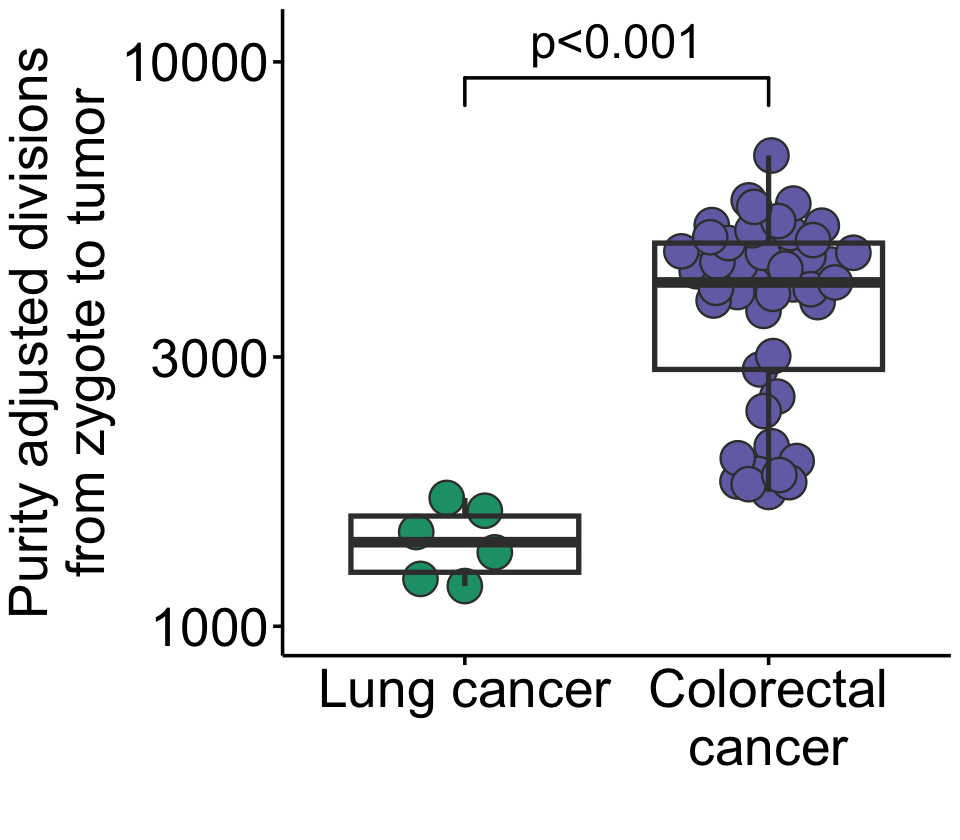

In [96]:
options(repr.plot.width=8, repr.plot.height=7)

dist_from_normal_corrected %>%
    mutate(cohort = "CRC") %>%
    bind_rows(luad_data) %>%
    mutate(cohort = fct_relevel(cohort, "LUAD", "CRC")) %>%
    ggplot(aes(cohort, divs)) +
    geom_quasirandom(aes(fill=cohort),  width=0.3, size=9, pch=21, color="grey23", stroke=1) +
    geom_boxplot(alpha=0, size=1.5, color="grey23") +
    scale_fill_manual(values = c("CRC"="#7570B3", "LUAD"="#1B9E77"),
                       guide="none") +
    stat_pvalue_manual(mut_burden_p, label = "p", tip.length = 0.015, step.increase = 0.04,
                      bracket.nudge.y = 0.1, size = 10, bracket.size = 1, vjust=-0.4) +
    labs(x = "", y = "Purity adjusted divisions\nfrom zygote to tumor", ) +
        theme_martin() +
        scale_y_log10() +
        coord_cartesian(ylim = c(1000, 11000)) +
        scale_x_discrete(labels = c("Lung cancer", "Colorectal\ncancer")) +
        theme(
            text = element_text(size = 20, color = "black"),
            axis.text = element_text(color = "black"),
            axis.ticks = element_line(color = "black")
        )
    
ggsave("../plots/Figure4/Extended_Data_Fig7b.pdf", height = 11, width = 11)
